#ADL -  PS 7 - Multi-task Autoencoders and Clustering
## Resources
- Some figures are taken from [here](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798).
- training code is modified from [here](https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py).

In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Autoencoder

![img](https://miro.medium.com/max/1400/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png)

## MNIST example

In [3]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# define parameters
num_epochs = 500
batch_size = 1024
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Get data from torchvision.datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Train on a random subset of 1k examples
N = 1000
torch.manual_seed(0)
np.random.seed(0)


# sample indicies
train_size = len(trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, N)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

# set sampler for trainset - note: no shuffle argument when sampler is provided
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_subset_sampler)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]


In [4]:
X_train = trainset.data
X_train = X_train.numpy()
print("before:", X_train.mean(), X_train.std())
X_train = (X_train - X_train.mean()) / X_train.std()
print("after:", X_train.mean(), X_train.std())

before: 33.318421449829934 78.56748998339798
after: -3.064638490070051e-17 0.9999999999999998


### Model
The Autoencoder model. Composed of fully-connected encoder
and decoder. Below, a **Multi-task Autoencoder (ML-AE)**.

Q1: Why are we using a code size of 2?

Q2: What are the advantages and disadvantages of a ML-AE compared with an AE?

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.code_size = 2
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64,
            self.code_size))


        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            #nn.Tanh())
        )

    def forward(self, x):
      # (batch_size, 784)
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        return recon, encoded_vector

## Multi-task Learning 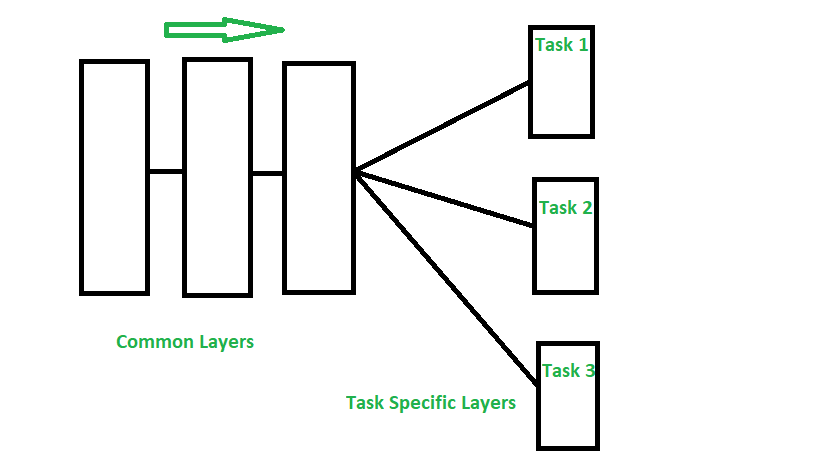

In [6]:
class ML_autoencoder(autoencoder):
    def __init__(self):
        # inhert from parent
        super(ML_autoencoder, self).__init__()
        self.n_classes = 10
        # Add classification head
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, self.n_classes),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        # (batch_size, 2)
        encoded_vector = self.encoder(x)
        # (batch_size, 784)
        recon = self.decoder(encoded_vector)
        # (batch_size, 10)
        preds = self.clf(encoded_vector)
        return recon, preds, encoded_vector

### Training
**Reconstruction loss:** We will compute the Mean-squared error (MSE) between the reconstructed images and the original ones.

**Classification loss:** If ML-AE is chosen, we will also compute the NLL between the class labels and the classification head predictions

In [7]:

from torch.nn.functional import pairwise_distance
triplet_loss = nn.TripletMarginLoss

def create_and_train_model(ml_ae=False, use_triplet_loss=False, margin=1.0, num_epochs=500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.MSELoss()
    clf_criterion = nn.NLLLoss()
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin)

    # Choose whether to use Multi-task AE or not
    if ml_ae:
        model = ML_autoencoder().to(device)
    # Standard AE or Triplet
    else:
        model = autoencoder().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Lists to hold loss across epochs
    loss_train_ae = []
    loss_train_clf = []
    loss_train_triplet = []

    for epoch in tqdm(range(num_epochs)):
        loss_epoch = 0
        loss_ae_epoch = 0
        loss_clf_epoch = 0
        loss_triplet_epoch = 0

        for data in trainloader:
            # Batch loss for updating the model
            loss = 0
            optimizer.zero_grad()
            img, labels = data
            img = img.view(img.size(0), -1).to(device)
            labels = labels.to(device)

            # Forward pass
            if ml_ae:
                recon, preds, embeddings = model(img)
            else:
                recon, embeddings = model(img)

            # Reconstruction loss
            loss_ae_batch = criterion(recon, img)
            loss += loss_ae_batch
            loss_ae_epoch += loss_ae_batch.item()

            if ml_ae:
              loss_clf_batch = clf_criterion(preds, labels)
              loss += loss_clf_batch
              loss_clf_epoch += loss_clf_batch.item()
              # Triplet loss
            if use_triplet_loss:
                # Generate triplets based on labels
                anchors, positives, negatives = create_triplets(img, labels, embeddings, device)
                loss_triplet_batch = triplet_loss_fn(anchors, positives, negatives)
                loss += loss_triplet_batch
                loss_triplet_epoch += loss_triplet_batch.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()

        # Record losses
        loss_train_ae.append(loss_ae_epoch / len(trainloader))
        if ml_ae:
            loss_train_clf.append(loss_clf_epoch / len(trainloader))
        if use_triplet_loss:
            loss_train_triplet.append(loss_triplet_epoch / len(trainloader))

    # Evaluation mode
    model.eval()

    # Plot losses
    plt.plot(loss_train_ae, label="Reconstruction loss")
    if use_triplet_loss:
        plt.plot(loss_train_triplet, label="Triplet loss")
    if ml_ae and not use_triplet_loss:
        plt.plot(loss_train_clf, label="Classification loss")


    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("AE Training Loss")
    plt.show()
    return model



### Inspect results

In [8]:
def get_imgs_and_recon(model, dataloader):
  # get one batch of imgs and their reconstruction
  torch.manual_seed(0)
  for data in dataloader:
    imgs, _ = data
    imgs = imgs.view(imgs.size(0), -1)
    imgs = Variable(imgs).to(device)
    imgs_recon = model.decoder(model.encoder(imgs))
    imgs, imgs_recon = imgs.view(-1,28,28), imgs_recon.view(-1,28,28)
    # return after 1 epoch
    return imgs.detach().cpu().numpy(), imgs_recon.detach().cpu().numpy()

In [9]:
def plot_images_and_recon(imgs, imgs_recon):

  figure1 = plt.figure(figsize=(10,3))
  num_of_images = 30
  for index in range(1, num_of_images + 1):
      plt.subplot(3, 10, index)
      plt.axis('off')
      plt.imshow(imgs[index].squeeze(), cmap='gray')
  plt.tight_layout()
  plt.suptitle("Original Batch", y=1.05, fontsize=20)

  figure2 = plt.figure(figsize=(10,3))
  num_of_images = 30
  for index in range(1, num_of_images + 1):
      plt.subplot(3, 10, index)
      plt.axis('off')
      plt.imshow(imgs_recon[index].squeeze(), cmap='gray')
  plt.suptitle("Reconstructed Batch", y=1.05, fontsize=20)
  plt.tight_layout()
  plt.show()

100%|██████████| 500/500 [01:36<00:00,  5.21it/s]


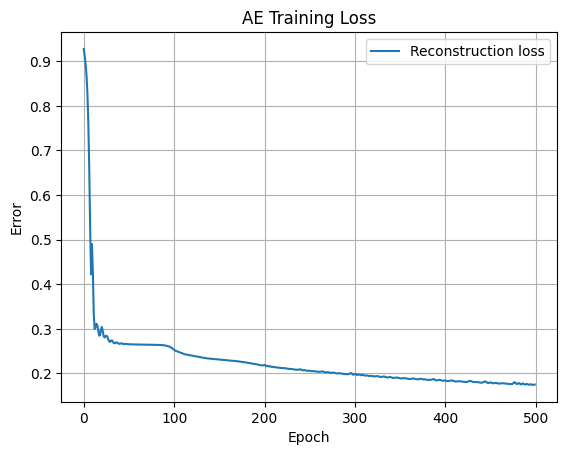

100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


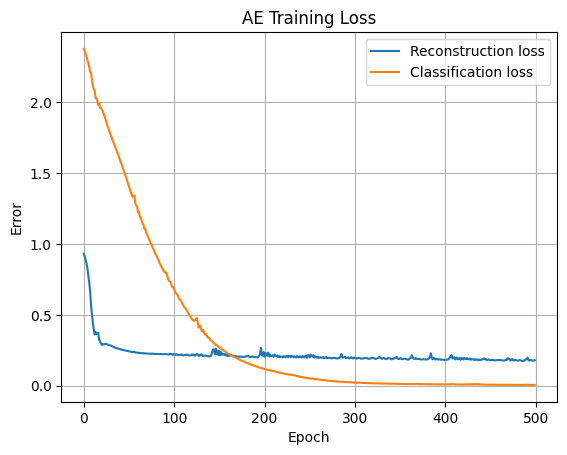

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ae = create_and_train_model(ml_ae=False, num_epochs=num_epochs)
model_mt_ae = create_and_train_model(ml_ae=True, num_epochs=num_epochs)


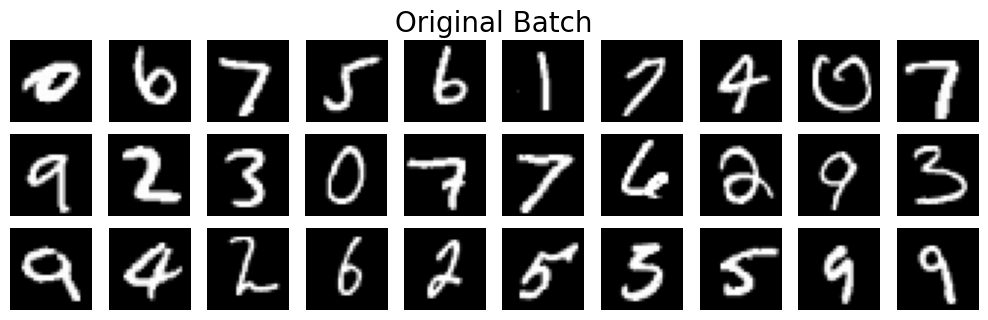

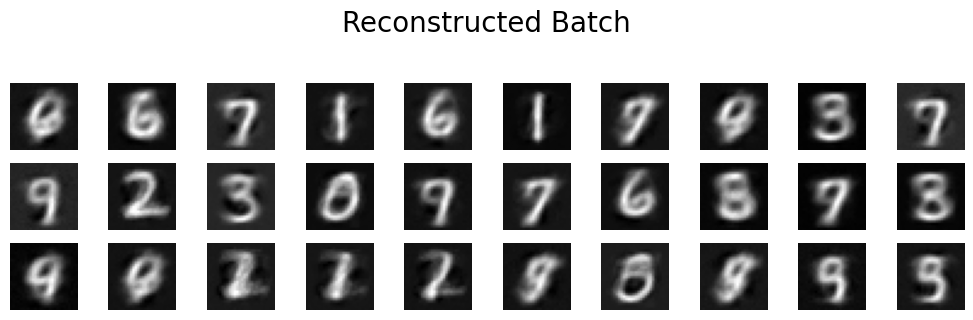

In [11]:
imgs, imgs_recon = get_imgs_and_recon(model_ae, trainloader)
plot_images_and_recon(imgs, imgs_recon )

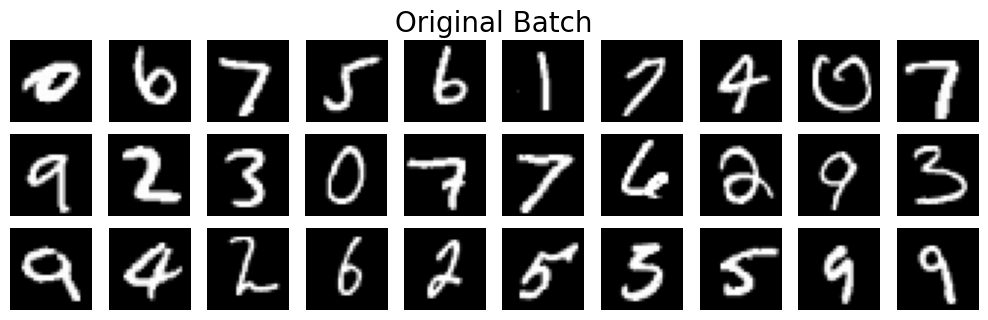

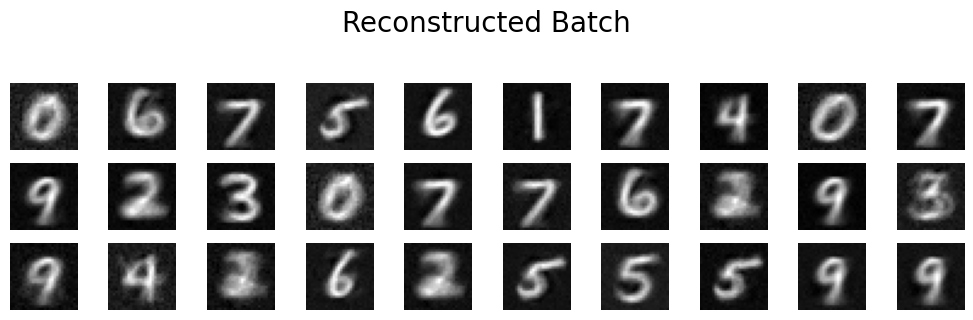

In [14]:
imgs, imgs_recon = get_imgs_and_recon(model_mt_ae, trainloader)
plot_images_and_recon(imgs, imgs_recon )
# gs_and_recon(model_mt_ae, trainloader)

## Visualize the encoded vectors
Let's visuzalise the encoding of the test data.

Where:

\begin{equation}
x\in R^{28x28}\\
encoder(x;\theta)=h;
h\in R^{2}
\end{equation}


In [15]:
import seaborn as sns

In [23]:
def visualize_embedding(X, y, title="MNIST test set econded vector (true labels)"):
  classes = np.unique(y)
  clrs = sns.color_palette('gist_rainbow', n_colors=10)  # a list of RGB tuples
  for k in classes:

    # Take samples within class
    Xk = X[y==k]
    yk = y[y==k]
    color = clrs[k]
    plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
  plt.legend()
  plt.title(title)
  plt.grid()


# def visualize_embedding(X, y, title="MNIST test set encoded vector (true labels)",
#                         xlim=None, ylim=None):
#     classes = np.unique(y)
#     clrs = sns.color_palette('gist_rainbow', n_colors=10)

#     # If limits not provided, compute from the data
#     if xlim is None:
#         xlim = (X[:,0].min(), X[:,0].max())
#     if ylim is None:
#         ylim = (X[:,1].min(), X[:,1].max())

#     plt.figure(figsize=(6,5))
#     for k in classes:
#         Xk = X[y == k]
#         plt.scatter(Xk[:, 0], Xk[:, 1], color=clrs[k], label=k, s=8)

#     plt.xlim(xlim)
#     plt.ylim(ylim)
#     plt.gca().set_aspect('equal', 'box')   # ← same scaling for x and y
#     plt.legend()
#     plt.title(title)
#     plt.grid(True)
#     plt.show()


def extract_emb_from_dataset(model, dataloader):
  model.eval()
  # we will create a list which will hold a concatination of all batches
  encoded_data = []
  labels_all = []
  for data in dataloader:
      img, labels = data
      img = img.view(img.size(0), -1)
      img = Variable(img).to(device)
      # ===================forward=====================
      # note how we call the encoder
      x_code = model.encoder(img)
      encoded_data.append(x_code.detach().cpu().numpy())
      labels_all.append(labels.cpu().numpy())
    # list of np.array to one large one
  X_coded = np.concatenate(encoded_data, axis=0)
  y_all = np.concatenate(labels_all, axis=0)
  return X_coded, y_all

In [24]:
X_code_ae, labels = extract_emb_from_dataset(model_ae, testloader)
X_code_mtae , labels = extract_emb_from_dataset(model_mt_ae, testloader)

res_dict = {
    "labels": labels,
    "AE": X_code_ae,
    "MT-AE":  X_code_mtae
}

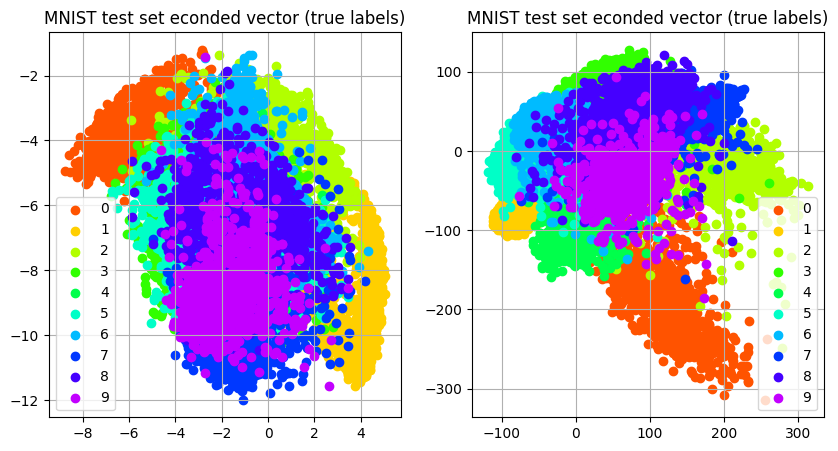

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(121)
visualize_embedding(res_dict["AE"], labels)
plt.subplot(122)
visualize_embedding(res_dict["MT-AE"], labels)

# Triplet Loss

The **Triplet Loss** is a metric learning objective designed to ensure that semantically similar data points are closer together in the embedding space while pushing dissimilar points farther apart. It is commonly used in applications such as face recognition and image retrieval.

## Definition

Given an **anchor** \( a \), a **positive** \( p \) (a sample from the same class as the anchor), and a **negative** \( n \) (a sample from a different class), the Triplet Loss is defined as:

$\
\mathcal{L}_{\text{triplet}} = \max \left( \| f(a) - f(p) \|_2^2 - \| f(a) - f(n) \|_2^2 + \alpha, 0 \right)
$

Where:
- $ f(x) $ represents the embedding function (e.g., a neural network mapping inputs to an embedding space).
- $ \| \cdot \|_2 $ denotes the Euclidean distance (or $ L_2 $-norm).
- $ \alpha $ is the **margin** that enforces a minimum separation between positive and negative pairs.

## Intuition

1. **Minimize Distance for Positives**:
   - The loss encourages the distance between the anchor and the positive (\( \| f(a) - f(p) \|_2 \)) to be small.

2. **Maximize Distance for Negatives**:
   - The loss ensures the anchor-negative distance $ \| f(a) - f(n) \|_2 $ is sufficiently larger than the anchor-positive distance by at least $\alpha$.

3. **Enforce Margin**:
   - The margin $\alpha$ prevents the model from collapsing embeddings into a trivial solution.

## Practical Notes

- **Triplet Sampling**: Carefully choosing triplets (e.g., hard negatives) is critical for effective training. Poor triplet selection may lead to slow convergence or suboptimal embeddings.
- **Embedding Space**: The embeddings are typically normalized to a unit sphere for numerical stability and better performance.

Triplet Loss is widely used to learn meaningful representations, making it a powerful tool for tasks requiring similarity-based comparisons.


In [19]:
def create_triplets(img, labels, embeddings, device):
    """
    Generate triplet batches (anchor, positive, negative) based on labels.
    """
    anchors, positives, negatives = [], [], []
    unique_labels = labels.unique()
    # iterate over labels (0, ..., 9) for MNIST.
    for label in unique_labels:
        label_mask = labels == label
        non_label_mask = ~label_mask

        # Embeddings for the current class (positives)
        positive_embeddings = embeddings[label_mask]

        # Embeddings for other classes (negatives)
        negative_embeddings = embeddings[non_label_mask]

        for anchor in positive_embeddings:
            positives.append(positive_embeddings[torch.randint(0, len(positive_embeddings), (1,))])
            negatives.append(negative_embeddings[torch.randint(0, len(negative_embeddings), (1,))])
            anchors.append(anchor)

    # Convert to tensors
    anchors = torch.stack(anchors).to(device)
    positives = torch.stack(positives).squeeze().to(device)
    negatives = torch.stack(negatives).squeeze().to(device)
    return anchors, positives, negatives

100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


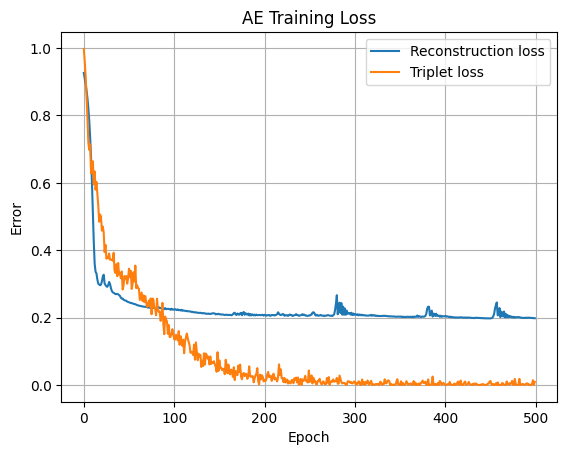

In [20]:
model_triplets = create_and_train_model(ml_ae=True, use_triplet_loss=True, margin=1.0, num_epochs=num_epochs)

In [21]:
X_code_tri, labels = extract_emb_from_dataset(model_triplets, testloader)

res_dict["MT-AE-Triplet"] = X_code_tri

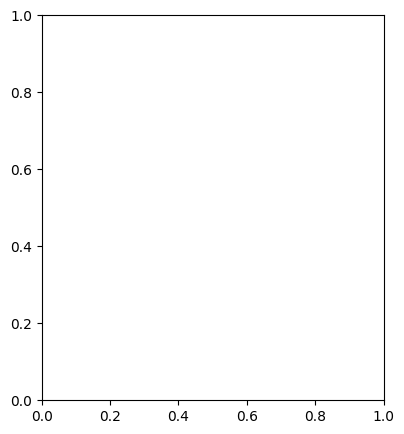

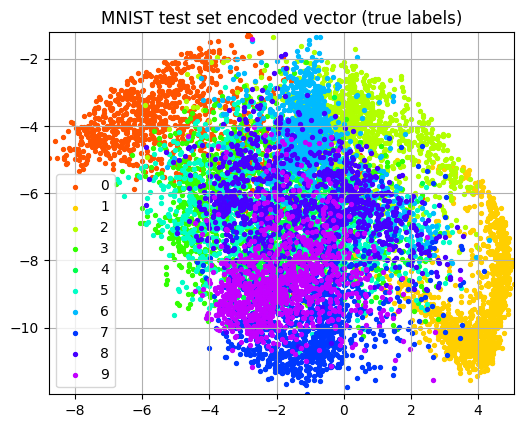

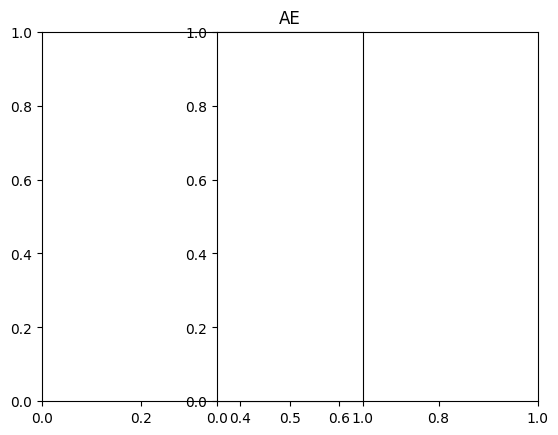

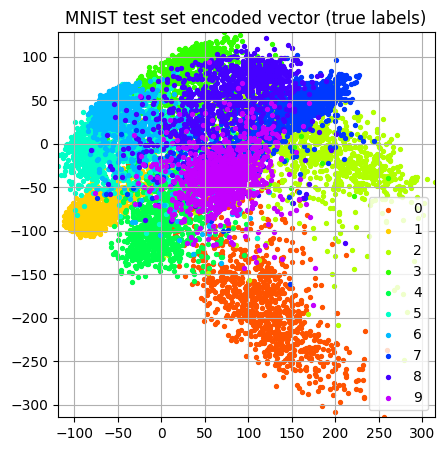

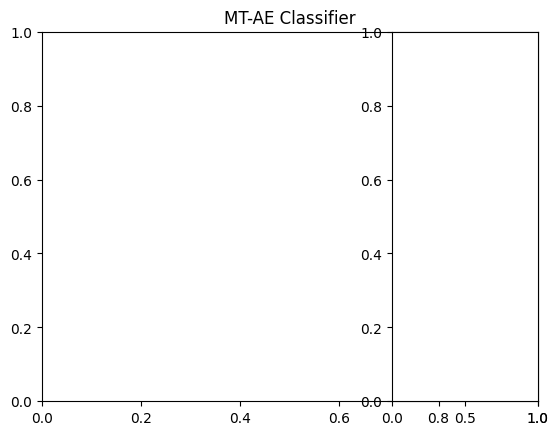

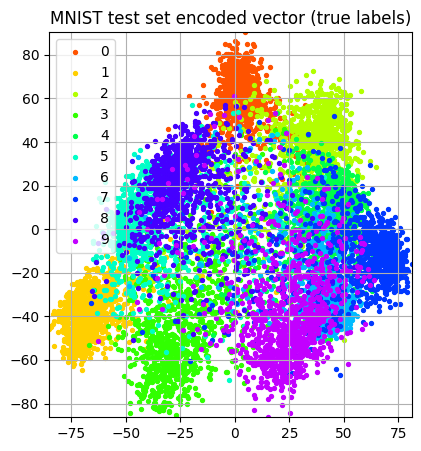

Text(0.5, 1.0, 'MT-AE Triplets')

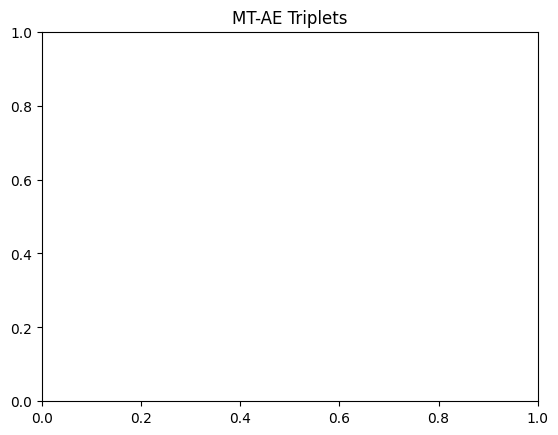

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(131)
visualize_embedding(res_dict["AE"], labels)
plt.title("AE")
plt.subplot(132)
visualize_embedding(res_dict["MT-AE"], labels)
plt.title("MT-AE Classifier")
plt.subplot(133)
visualize_embedding(res_dict["MT-AE-Triplet"], labels)
plt.title("MT-AE Triplets")